In [1]:
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import random

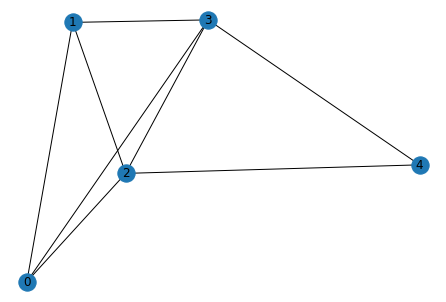

In [2]:
np.random.seed(50)
n_nodes=5
graph = [(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]
G=nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G,with_labels=True)

In [3]:
def initialization():
    for i in range(n_nodes):
        qml.Hadamard(wires=i)

In [4]:
def cost_unitary(gamma):
    for edge in graph:
        qml.MultiRZ(gamma*edge[2], wires=[edge[0],edge[1]])

In [5]:
def mixture_unitary(alpha):
    for i in range(n_nodes):
        qml.RX(alpha,wires=i)

In [6]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

In [7]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)

dev = qml.device("default.qubit", wires = n_nodes, analytic=True, shots=1)
@qml.qnode(dev)
def circuit(gammas, alphas, edge=None, n_layers=1):
    initialization()
    for i in range(n_layers):
        cost_unitary(gammas[i])
        mixture_unitary(alphas[i])
    if edge is None:
        return qml.sample(comp_basis_measurement(range(n_nodes)))
    return qml.expval(qml.Hermitian(pauli_z_2, wires=[edge[0],edge[1]]))

In [8]:
def create_params(params):
    alphas = []
    gammas = []
    for i in range(int(len(params)/2)):
        gammas.append(params[2*i])
        alphas.append(params[2*i+1])
    return gammas , alphas

In [9]:
def cost(params):
    gammas, alphas = create_params(params)
    cost = 0
    for edge in graph:
        cost -= 0.5 * (1 - edge[2]*circuit(gammas, alphas, edge=edge, n_layers=int(len(params)/2)))
    return cost

In [10]:
def qaoa_maxcut(n_layers=1, steps = 30, n_samples = 100):
    print("\np={:d}".format(n_layers))
    init = np.array([float(random.randint(-314, 314))/float(10000) for i in range(0, 2*n_layers)])    
    opt = qml.AdagradOptimizer(stepsize=0.5)
    params = init
    collect_costs = []
    for i in range(steps):
        params = opt.step(cost, params)
        if (i + 1) % 5 == 0:
            c = cost(params)
            collect_costs.append(c)
            print("Objective after step {:5d}: {: .7f}".format(i + 1, c))
            
            
    bit_strings = []
    n_samples = 100
    opt_gammas, opt_alphas = create_params(params)
    for i in range(0, n_samples):
        bit_strings.append(int(circuit(opt_gammas, opt_alphas, edge=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized gamma vectors:\n{}".format(opt_gammas))
    print("Optimized alphas vectors:\n{}".format(opt_alphas))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return (cost(params), bit_strings,collect_costs)

In [11]:
results1 = qaoa_maxcut(n_layers=1,steps=120,n_samples = 100)
results2 = qaoa_maxcut(n_layers=2,steps=120,n_samples = 100)


p=1
Objective after step     5: -6.2715971
Objective after step    10: -8.1690700
Objective after step    15: -8.5436608
Objective after step    20: -8.7795555
Objective after step    25: -8.8511313
Objective after step    30: -8.8824238
Objective after step    35: -8.8933358
Objective after step    40: -8.8976936
Objective after step    45: -8.8992937
Objective after step    50: -8.8999122
Objective after step    55: -8.9001438
Objective after step    60: -8.9002323
Objective after step    65: -8.9002656
Objective after step    70: -8.9002783
Objective after step    75: -8.9002831
Objective after step    80: -8.9002849
Objective after step    85: -8.9002856
Objective after step    90: -8.9002859
Objective after step    95: -8.9002860
Objective after step   100: -8.9002860
Objective after step   105: -8.9002860
Objective after step   110: -8.9002860
Objective after step   115: -8.9002860
Objective after step   120: -8.9002860
Optimized gamma vectors:
[tensor(-0.42505731, requires_grad

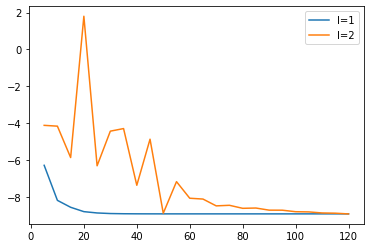

In [16]:
y1 = results1[2] 
y2 = results2[2]
X = []
for i in range(120):
    if (i + 1) % 5 == 0:
        X.append(i+1)
plt.plot(X,y1)
plt.plot(X,y2)
plt.legend(["l=1", "l=2"], loc ="upper right")
  
plt.show()

In [17]:
results3 = qaoa_maxcut(n_layers=3,steps=220,n_samples = 300)
results4 = qaoa_maxcut(n_layers=4,steps=220,n_samples = 400)


p=3
Objective after step     5: -5.7413522
Objective after step    10: -4.1873807
Objective after step    15: -6.1740964
Objective after step    20: -5.6878751
Objective after step    25: -6.2739738
Objective after step    30: -9.1052914
Objective after step    35: -6.6729931
Objective after step    40: -7.4013117
Objective after step    45: -8.3325211
Objective after step    50: -7.2102473
Objective after step    55: -7.7170356
Objective after step    60: -8.6877877
Objective after step    65: -8.3639238
Objective after step    70: -8.8654933
Objective after step    75: -8.7184507
Objective after step    80: -9.1269377
Objective after step    85: -9.0743751
Objective after step    90: -9.3565235
Objective after step    95: -9.3648675
Objective after step   100: -9.5586547
Objective after step   105: -9.5931900
Objective after step   110: -9.7266721
Objective after step   115: -9.7671250
Objective after step   120: -9.8592983
Objective after step   125: -9.8964554
Objective after step

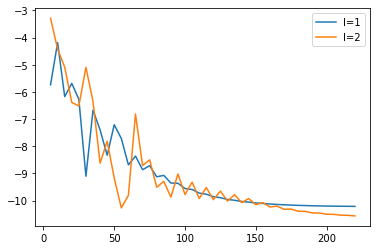

In [24]:
y3 = results3[2] 
y4 = results4[2]
X2 = []
for i in range(220):
    if (i + 1) % 5 == 0:
        X2.append(i+1)
plt.plot(X2,y3)
plt.plot(X2,y4)
plt.legend(["l=1", "l=2"], loc ="upper right")
  
plt.show()

In [25]:
results5 = qaoa_maxcut(n_layers=5,steps=240,n_samples = 500)


p=5
Objective after step     5: -4.8052068
Objective after step    10: -0.8351835
Objective after step    15: -4.9091271
Objective after step    20: -4.8082472
Objective after step    25: -4.4186616
Objective after step    30: -4.5427637
Objective after step    35: -5.3202763
Objective after step    40: -7.4038201
Objective after step    45: -7.7349803
Objective after step    50: -7.4819170
Objective after step    55: -8.7673012
Objective after step    60: -8.0771546
Objective after step    65: -9.0482790
Objective after step    70: -8.8713657
Objective after step    75: -9.1479292
Objective after step    80: -9.1414210
Objective after step    85: -9.3193895
Objective after step    90: -9.1636776
Objective after step    95: -9.7290429
Objective after step   100: -9.7657787
Objective after step   105: -10.1786988
Objective after step   110: -10.3731600
Objective after step   115: -9.9613421
Objective after step   120: -10.5160067
Objective after step   125: -10.2642749
Objective after 

In [26]:
results6 = qaoa_maxcut(n_layers=6,steps=240,n_samples = 500)


p=6
Objective after step     5: -3.1667527
Objective after step    10: -1.7530234
Objective after step    15: -5.3107723
Objective after step    20: -6.4709320
Objective after step    25: -5.7259732
Objective after step    30: -7.3375603
Objective after step    35: -7.9491269
Objective after step    40: -7.2583033
Objective after step    45: -6.9961640
Objective after step    50: -6.1934596
Objective after step    55: -7.3571509
Objective after step    60: -6.9552282
Objective after step    65: -9.1876092
Objective after step    70: -8.5012528
Objective after step    75: -8.1077583
Objective after step    80: -7.4219887
Objective after step    85: -8.7434805
Objective after step    90: -7.7535670
Objective after step    95: -8.9473001
Objective after step   100: -9.0472020
Objective after step   105: -8.8824669
Objective after step   110: -8.8261023
Objective after step   115: -9.2188231
Objective after step   120: -8.8713049
Objective after step   125: -9.7200593
Objective after step

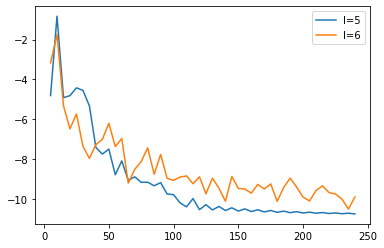

In [28]:
y5 = results5[2]
y6 = results6[2]
X3=[]
for i in range(240):
    if (i+1) % 5 == 0:
        X3.append(i+1)
plt.plot(X3,y5)
plt.plot(X3,y6)
plt.legend(["l=5", "l=6"], loc ="upper right")
  
plt.show()

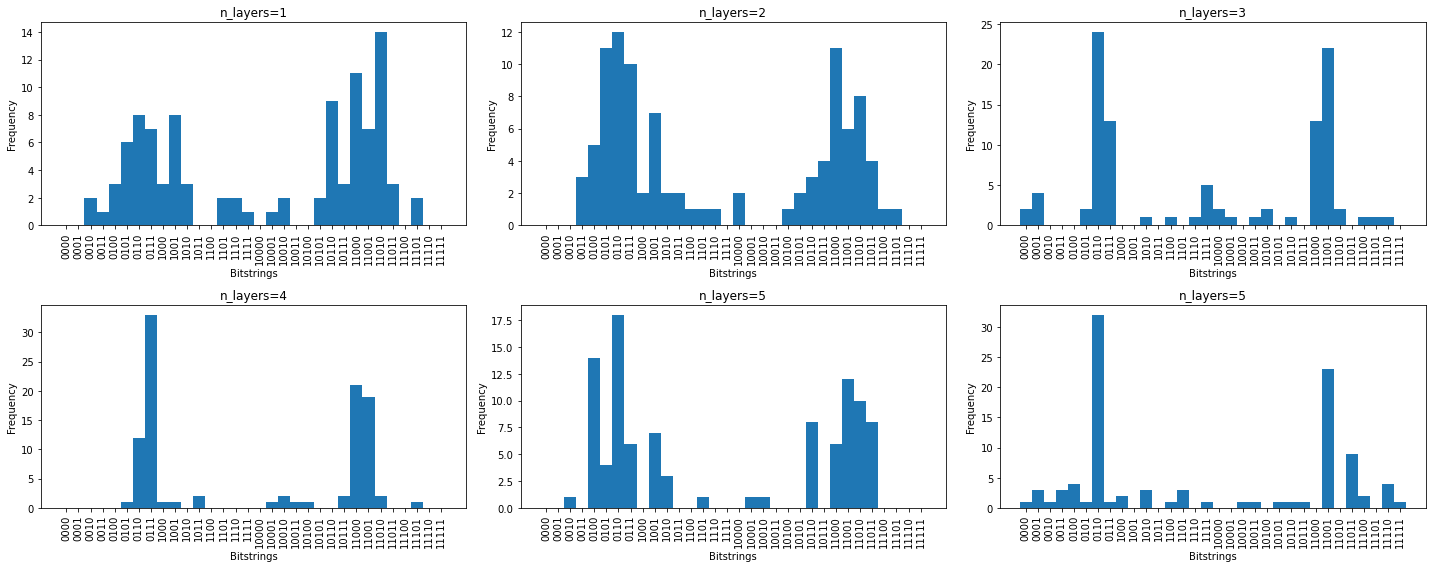

In [29]:
xticks = range(0, 32)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 33) - 0.5

fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(20, 8))

plt.subplot(2, 3, 1)
plt.title("n_layers=1")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(results1[1], bins=bins)

plt.subplot(2, 3, 2)
plt.title("n_layers=2")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(results2[1], bins=bins)

plt.subplot(2, 3, 3)
plt.title("n_layers=3")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(results3[1], bins=bins)

plt.subplot(2, 3, 4)
plt.title("n_layers=4")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(results4[1], bins=bins)

plt.subplot(2, 3, 5)
plt.title("n_layers=5")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(results5[1], bins=bins)

plt.subplot(2, 3, 6)
plt.title("n_layers=6")
plt.xlabel("Bitstrings")
plt.ylabel("Frequency")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(results6[1], bins=bins)

plt.tight_layout()
plt.show()